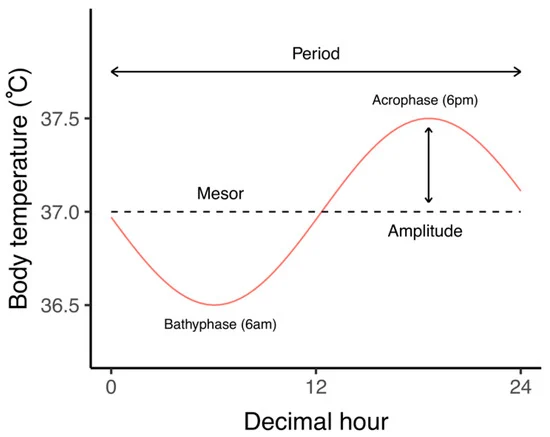

In [59]:
from PIL import Image
from IPython.display import display

image = Image.open("/home/coldrand/pyTBI-data/data/biology-10-00065-g002-550.webp")
display(image)


## MESOR considering 12 days, TBI - 6 and TBI + 6

/tmp/ipykernel_17377/924210853.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['date_time'])
/tmp/ipykernel_17377/924210853.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['date_time'])
/tmp/ipykernel_17377/924210853.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

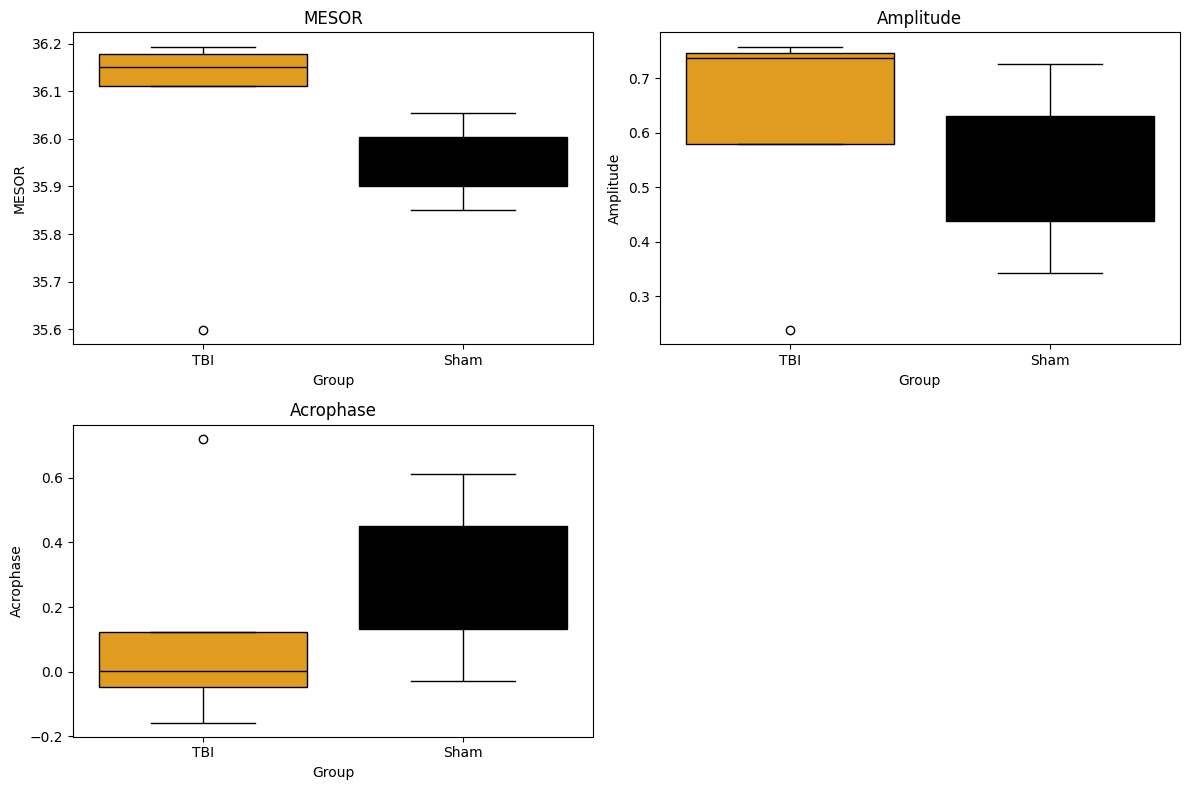

/tmp/ipykernel_17377/924210853.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='Mesor', data=all_results, palette=palette)
/tmp/ipykernel_17377/924210853.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='Amplitude', data=all_results, palette=palette)
/tmp/ipykernel_17377/924210853.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='Acrophase', data=all_results, palette=palette)
/tmp/ipykernel_17377/924210853.py:146: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 

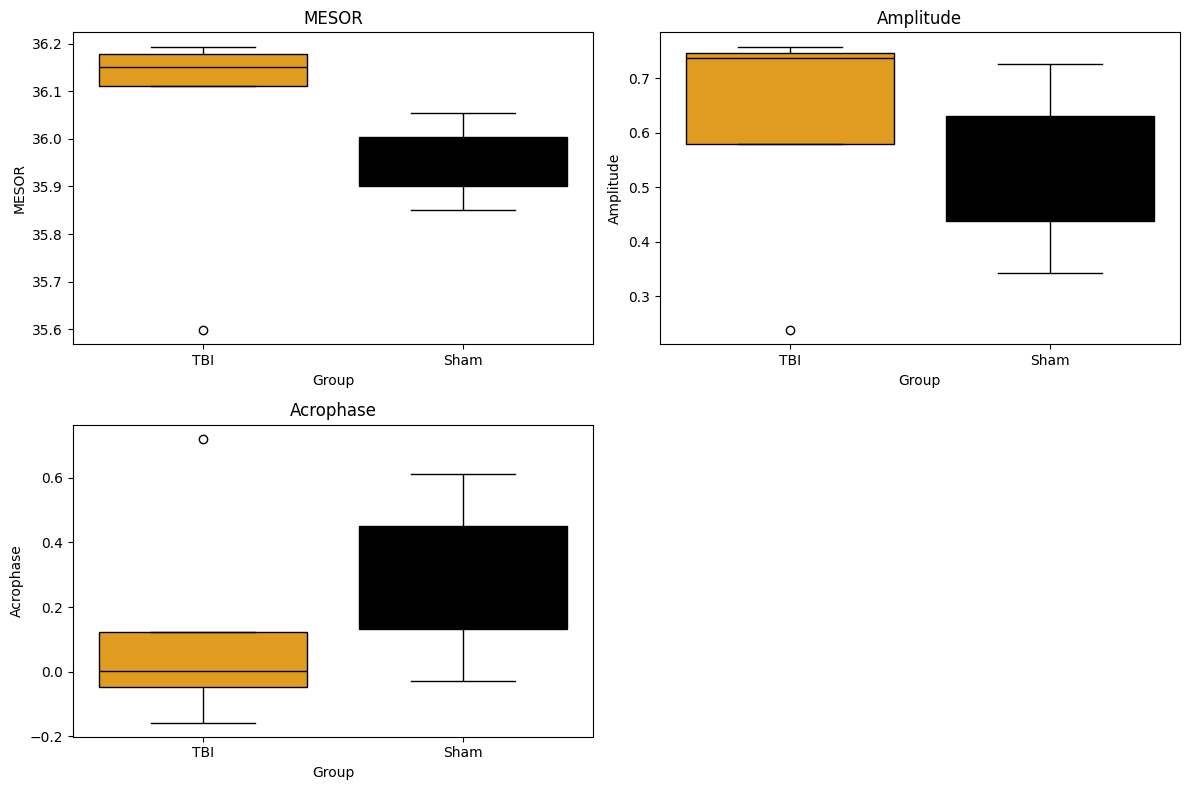

In [71]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from statsmodels.formula.api import mixedlm

# 1. Load the Metadata (unchanged)
metadata_path = '/home/coldrand/pyTBI-data/data/TBI_experiment/metadata.csv'
metadata = pd.read_csv(metadata_path, parse_dates=['tbi_date'])

# 2. Create a dictionary to map each animal to its TBI date (unchanged)
tbi_dates = metadata.set_index('animal')['tbi_date'].to_dict()

# 3. Exclusions and environmental parameters
# List of animal_experiment pairs to exclude
animal_exp_to_exclude = ["2_3", "10_4", "1_8", "2_5", "9_8", "3_5", "5_7", "8_3", "1_4", "7_4"]

# Set the hours after midnight that lights turn on and off in the vivarium
lights_on = 6
lights_off = 18

# 4. Folder path for experiment data (unchanged)
folder_path = '/home/coldrand/pyTBI-data/data/TBI_experiment/15min/'

# 5. Load experiment data (modified to skip excluded pairs)
file_paths = glob.glob(os.path.join(folder_path, '*.xlsx'))
temperature_data = {}
animals = range(1, 11)
experiments = [3, 4, 5, 7, 8]

for animal in animals:
    temperature_data[animal] = {}
    for exp in experiments:
        animal_exp = f'{animal}_{exp}'
        if animal_exp not in animal_exp_to_exclude:
            file_name = f'bruna{animal}_{exp}.xlsx'
            file_path = os.path.join(folder_path, file_name)
            if os.path.exists(file_path):
                df = pd.read_excel(file_path)
                temperature_data[animal][exp] = df

# 6. Trimming function (unchanged)
def trim_data(data, tbi_date=None, days_before=6, days_after=6, temp_min=34, temp_max=39):
    if tbi_date:
        start_date = tbi_date - pd.Timedelta(days=days_before)
        end_date = tbi_date + pd.Timedelta(days=days_after)
    else:
        in_range = data[(data['temp'] >= temp_min) & (data['temp'] <= temp_max)]
        if in_range.empty:
            print("No data found within the specified temperature range.")
            return pd.DataFrame()
        start_date = in_range['date_time'].iloc[0]
        end_date = in_range['date_time'].iloc[-1]

    trimmed_data = data[(data['date_time'] >= start_date) & (data['date_time'] <= end_date)]
    return trimmed_data

# 7. Cosinor model function (unchanged)
def cosinor_model(time, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos((2 * np.pi * time / 24) - acrophase)

# 8. Perform Cosinor Analysis and Save Results
def perform_cosinor_analysis(group_data, tbi_dates):
    results = {'animal': [], 'group': [], 'experiment': [], 'Mesor': [], 'Amplitude': [], 'Acrophase': []}
    for animal, experiments in group_data.items():
        group = 'TBI' if animal in [2, 3, 6, 7, 8] else 'Sham'
        for exp, data in experiments.items():
            tbi_date = tbi_dates.get(animal)
            data = trim_data(data, tbi_date)

            if data.empty:
                continue

            data['time'] = pd.to_datetime(data['date_time'])
            time_in_minutes = (data['time'] - data['time'].min()).dt.total_seconds() / 60
            time_in_hours = time_in_minutes / 60
            temperature = data['temp'].values

            if len(temperature) == 0:
                continue

            guess = [temperature.mean(), (temperature.max() - temperature.min()) / 2, 0]

            try:
                params, _ = curve_fit(cosinor_model, time_in_hours, temperature, p0=guess)
                mesor, amplitude, acrophase = params

                results['animal'].append(animal)
                results['group'].append(group)
                results['experiment'].append(exp)
                results['Mesor'].append(mesor)
                results['Amplitude'].append(amplitude)
                results['Acrophase'].append(acrophase)

            except RuntimeError as e:
                print(f"Curve fitting failed for animal {animal} experiment {exp}: {e}")
                continue

    return pd.DataFrame(results)

# 9. Collect and process the results
tbi_group_data = {animal: temperature_data[animal] for animal in [2, 3, 6, 7, 8]}
sham_group_data = {animal: temperature_data[animal] for animal in [4, 5]}

tbi_results = perform_cosinor_analysis(tbi_group_data, tbi_dates)
sham_results = perform_cosinor_analysis(sham_group_data, tbi_dates)

all_results = pd.concat([tbi_results, sham_results])

# 10. Visualization
plt.figure(figsize=(12, 8))

# Define the color palette
palette = {'Sham': 'black', 'TBI': 'orange'}

# MESOR plot
plt.subplot(2, 2, 1)
sns.boxplot(x='group', y='Mesor', data=all_results, palette=palette)
plt.title('MESOR')
plt.xlabel('Group')
plt.ylabel('MESOR')

# Amplitude plot
plt.subplot(2, 2, 2)
sns.boxplot(x='group', y='Amplitude', data=all_results, palette=palette)
plt.title('Amplitude')
plt.xlabel('Group')
plt.ylabel('Amplitude')

# Acrophase plot
plt.subplot(2, 2, 3)
sns.boxplot(x='group', y='Acrophase', data=all_results, palette=palette)
plt.title('Acrophase')
plt.xlabel('Group')
plt.ylabel('Acrophase')

plt.tight_layout()
plt.show()

# Save the results to a PDF
pdf_filename = 'cosinor_group_comparison.pdf'
with PdfPages(pdf_filename) as pdf:
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(x='group', y='Mesor', data=all_results, palette=palette)
    plt.title('MESOR')
    plt.xlabel('Group')
    plt.ylabel('MESOR')
    
    plt.subplot(2, 2, 2)
    sns.boxplot(x='group', y='Amplitude', data=all_results, palette=palette)
    plt.title('Amplitude')
    plt.xlabel('Group')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 2, 3)
    sns.boxplot(x='group', y='Acrophase', data=all_results, palette=palette)
    plt.title('Acrophase')
    plt.xlabel('Group')
    plt.ylabel('Acrophase')
    
    plt.tight_layout()
    # Save the plot as TIFF and SVG
tiff_filename = 'cosinor_group_comparison.tiff'
svg_filename = 'cosinor_group_comparison.svg'
plt.savefig(tiff_filename, format='tiff', dpi=300)
plt.savefig(svg_filename, format='svg')

plt.show()


# MESOR split in two groups: TBI-6days and TBI+6days

/tmp/ipykernel_379/1925346749.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['date_time'])
/tmp/ipykernel_379/1925346749.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['date_time'])
/tmp/ipykernel_379/1925346749.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

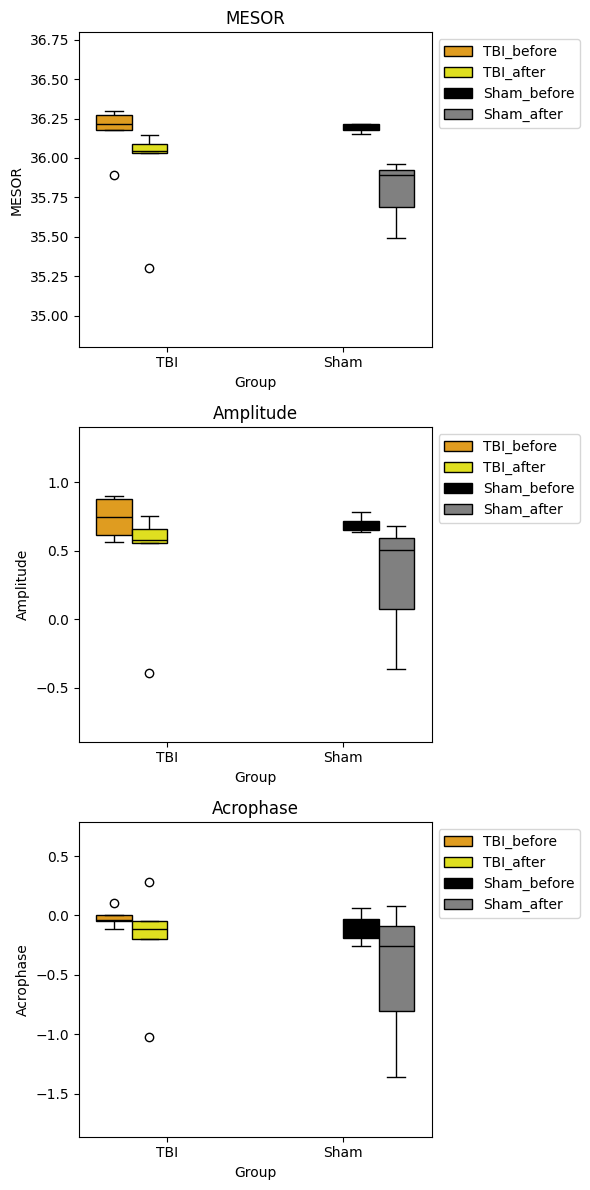

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.formula.api import mixedlm

# 1. Load the Metadata (unchanged)
metadata_path = '/home/coldrand/pyTBI-data/data/TBI_experiment/metadata.csv'
metadata = pd.read_csv(metadata_path, parse_dates=['tbi_date'])

# 2. Create a dictionary to map each animal to its TBI date (unchanged)
tbi_dates = metadata.set_index('animal')['tbi_date'].to_dict()

# 3. Exclusions and environmental parameters
# List of animal_experiment pairs to exclude
animal_exp_to_exclude = ["2_3", "10_4", "1_8", "2_5", "9_8", "3_5", "5_7", "8_3", "1_4", "7_4"]

# Set the hours after midnight that lights turn on and off in the vivarium
lights_on = 6
lights_off = 18

# 4. Folder path for experiment data (unchanged)
folder_path = '/home/coldrand/pyTBI-data/data/TBI_experiment/15min/'

# 5. Load experiment data (modified to skip excluded pairs)
file_paths = glob.glob(os.path.join(folder_path, '*.xlsx'))
temperature_data = {}
animals = range(1, 11)
experiments = [3, 4, 5, 7, 8]

for animal in animals:
    temperature_data[animal] = {}
    for exp in experiments:
        animal_exp = f'{animal}_{exp}'
        if animal_exp not in animal_exp_to_exclude:
            file_name = f'bruna{animal}_{exp}.xlsx'
            file_path = os.path.join(folder_path, file_name)
            if os.path.exists(file_path):
                df = pd.read_excel(file_path)
                temperature_data[animal][exp] = df

# Separate the data into TBI and Sham groups
tbi_group_data = {animal: temperature_data[animal] for animal in [2, 3, 6, 7, 8] if animal in temperature_data}
sham_group_data = {animal: temperature_data[animal] for animal in [1, 4, 5, 9, 10] if animal in temperature_data}

# 6. Trimming function (unchanged)
def trim_data(data, tbi_date=None, days_before=6, days_after=6, temp_min=34, temp_max=39):
    if tbi_date:
        start_date = tbi_date - pd.Timedelta(days=days_before)
        end_date = tbi_date + pd.Timedelta(days=days_after)
    else:
        in_range = data[(data['temp'] >= temp_min) & (data['temp'] <= temp_max)]
        if in_range.empty:
            print("No data found within the specified temperature range.")
            return pd.DataFrame()
        start_date = in_range['date_time'].iloc[0]
        end_date = in_range['date_time'].iloc[-1]

    trimmed_data = data[(data['date_time'] >= start_date) & (data['date_time'] <= end_date)]
    return trimmed_data

# 7. Cosinor model function (unchanged)
def cosinor_model(time, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos((2 * np.pi * time / 24) - acrophase)

# 8. Perform Cosinor Analysis and Save Results with separate windows
def perform_cosinor_analysis(group_data, tbi_dates, analysis_window='both'):
    results = {'animal': [], 'group': [], 'experiment': [], 'window': [], 'Mesor': [], 'Amplitude': [], 'Acrophase': []}
    
    for animal, experiments in group_data.items():
        group = 'TBI' if animal in [2, 3, 6, 7, 8] else 'Sham'
        for exp, data in experiments.items():
            tbi_date = tbi_dates.get(animal)
            
            if analysis_window in ['both', 'before']:
                # Analyze 6 days before TBI
                before_data = trim_data(data, tbi_date, days_before=6, days_after=0)
                if not before_data.empty:
                    perform_fit_and_store_results(before_data, animal, group, exp, 'before', results)
            
            if analysis_window in ['both', 'after']:
                # Analyze 6 days after TBI
                after_data = trim_data(data, tbi_date, days_before=0, days_after=6)
                if not after_data.empty:
                    perform_fit_and_store_results(after_data, animal, group, exp, 'after', results)

    return pd.DataFrame(results)

def perform_fit_and_store_results(data, animal, group, exp, window, results):
    data['time'] = pd.to_datetime(data['date_time'])
    time_in_minutes = (data['time'] - data['time'].min()).dt.total_seconds() / 60
    time_in_hours = time_in_minutes / 60
    temperature = data['temp'].values

    if len(temperature) == 0:
        return

    guess = [temperature.mean(), (temperature.max() - temperature.min()) / 2, 0]

    try:
        params, _ = curve_fit(cosinor_model, time_in_hours, temperature, p0=guess)
        mesor, amplitude, acrophase = params

        results['animal'].append(animal)
        results['group'].append(group)
        results['experiment'].append(exp)
        results['window'].append(window)
        results['Mesor'].append(mesor)
        results['Amplitude'].append(amplitude)
        results['Acrophase'].append(acrophase)

    except RuntimeError as e:
        print(f"Curve fitting failed for animal {animal} experiment {exp} ({window} window): {e}")

# 9. Collect and process the results
tbi_results = perform_cosinor_analysis(tbi_group_data, tbi_dates, analysis_window='both')
sham_results = perform_cosinor_analysis(sham_group_data, tbi_dates, analysis_window='both')

all_results = pd.concat([tbi_results, sham_results])

# 10. Save results to a CSV file
csv_filename = 'cosinor_group_comparison_results.csv'
all_results.to_csv(csv_filename, index=False)

# 11. Visualization

# Combine 'group' and 'window' into a new column
all_results['group_window'] = all_results['group'] + '_' + all_results['window']

# Define a palette that matches the combined 'group_window' variable
palette = {
    'Sham_before': 'black',
    'Sham_after': 'gray',
    'TBI_before': 'orange',
    'TBI_after': 'yellow'
}

# Visualization
plt.figure(figsize=(6, 12))  # Adjusted to be narrower and taller

# MESOR plot
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first plot
sns.boxplot(x='group', y='Mesor', hue='group_window', data=all_results, palette=palette)
plt.title('MESOR')
plt.xlabel('Group')
plt.ylabel('MESOR')
plt.ylim(all_results['Mesor'].min() - 0.5, all_results['Mesor'].max() + 0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Amplitude plot
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second plot
sns.boxplot(x='group', y='Amplitude', hue='group_window', data=all_results, palette=palette)
plt.title('Amplitude')
plt.xlabel('Group')
plt.ylabel('Amplitude')
plt.ylim(all_results['Amplitude'].min() - 0.5, all_results['Amplitude'].max() + 0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Acrophase plot
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third plot
sns.boxplot(x='group', y='Acrophase', hue='group_window', data=all_results, palette=palette)
plt.title('Acrophase')
plt.xlabel('Group')
plt.ylabel('Acrophase')
plt.ylim(all_results['Acrophase'].min() - 0.5, all_results['Acrophase'].max() + 0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

# Save the plot as TIFF and SVG
tiff_filename = 'cosinor_group_comparison_plot.tiff'
svg_filename = 'cosinor_group_comparison_plot.svg'
plt.savefig(tiff_filename, format='tiff', dpi=300)
plt.savefig(svg_filename, format='svg')

plt.show()

# Save the results to a PDF
pdf_filename = 'cosinor_group_comparison_before_after.pdf'
with PdfPages(pdf_filename) as pdf:
    plt.figure(figsize=(6, 12))
    
    plt.subplot(3, 1, 1)
    sns.boxplot(x='group', y='Mesor', hue='group_window', data=all_results, palette=palette)
    plt.title('MESOR')
    plt.xlabel('Group')
    plt.ylabel('MESOR')
    plt.ylim(all_results['Mesor'].min() - 0.5, all_results['Mesor'].max() + 0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.subplot(3, 1, 2)
    sns.boxplot(x='group', y='Amplitude', hue='group_window', data=all_results, palette=palette)
    plt.title('Amplitude')
    plt.xlabel('Group')
    plt.ylabel('Amplitude')
    plt.ylim(all_results['Amplitude'].min() - 0.5, all_results['Amplitude'].max() + 0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.subplot(3, 1, 3)
    sns.boxplot(x='group', y='Acrophase', hue='group_window', data=all_results, palette=palette)
    plt.title('Acrophase')
    plt.xlabel('Group')
    plt.ylabel('Acrophase')
    plt.ylim(all_results['Acrophase'].min() - 0.5, all_results['Acrophase'].max() + 0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    pdf.savefig()
    plt.close()

# Senoids comparison

/tmp/ipykernel_17377/4020057178.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['time_in_hours'] = (trimmed_data['date_time'] - trimmed_data['date_time'].min()).dt.total_seconds() / 3600
/tmp/ipykernel_17377/4020057178.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['time_in_hours'] = (trimmed_data['date_time'] - trimmed_data['date_time'].min()).dt.total_seconds() / 3600
/tmp/ipykernel_17377/4020057178.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Sham Before Period: Mesor=36.19, Amplitude=0.69, Acrophase=-0.11, Bathyphase=11.89
Sham After Period: Mesor=35.78, Amplitude=0.38, Acrophase=0.25, Bathyphase=12.25


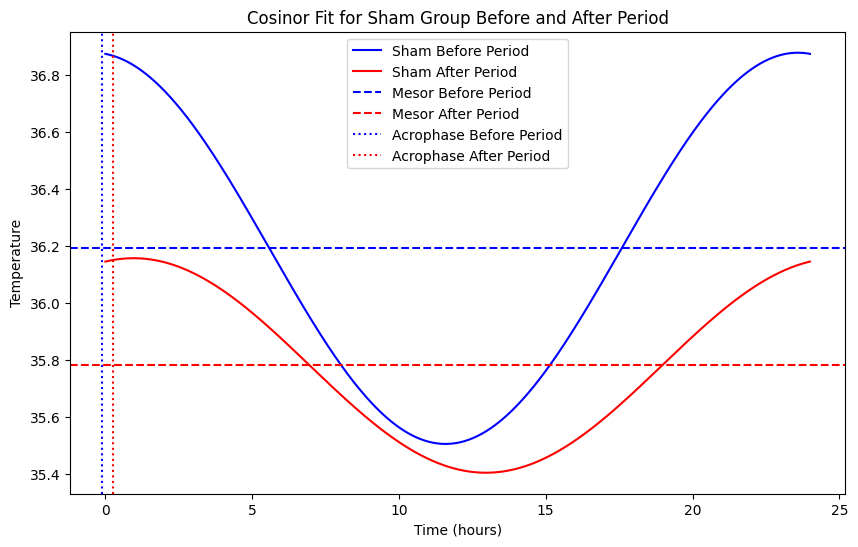

/tmp/ipykernel_17377/4020057178.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['time_in_hours'] = (trimmed_data['date_time'] - trimmed_data['date_time'].min()).dt.total_seconds() / 3600
/tmp/ipykernel_17377/4020057178.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['time_in_hours'] = (trimmed_data['date_time'] - trimmed_data['date_time'].min()).dt.total_seconds() / 3600
/tmp/ipykernel_17377/4020057178.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy 

TBI Before Period: Mesor=36.17, Amplitude=0.74, Acrophase=-0.02, Bathyphase=11.98
TBI After Period: Mesor=35.92, Amplitude=0.46, Acrophase=0.12, Bathyphase=12.12


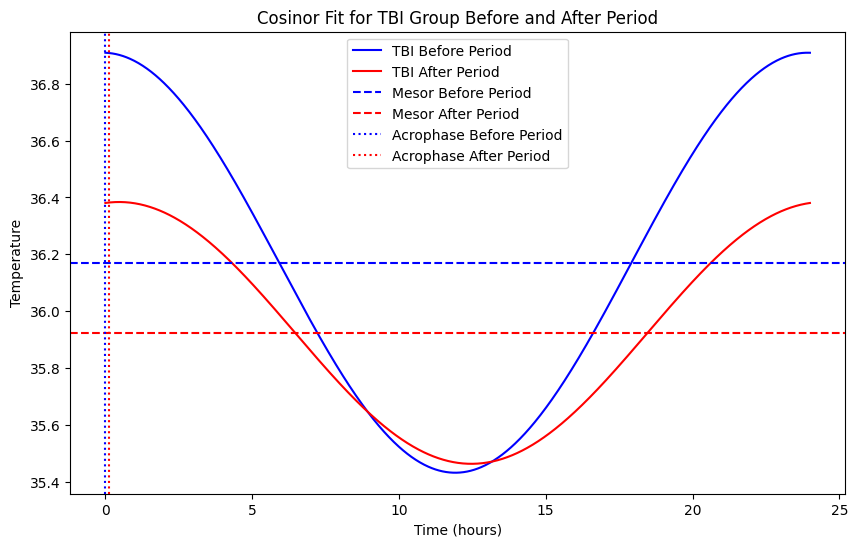

Sham TIFF: Sham_cosinor_plot.tiff, Sham SVG: Sham_cosinor_plot.svg
TBI TIFF: TBI_cosinor_plot.tiff, TBI SVG: TBI_cosinor_plot.svg


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate and plot the Cosinor parameters for a given group
def calculate_and_plot_cosinor(temperature_data, tbi_dates, group_name, animal_ids):
    # Function to filter the data and prepare it for fitting
    def prepare_data(animal, exp, data, tbi_date, window):
        if window == 'before':
            trimmed_data = trim_data(data, tbi_date, days_before=6, days_after=0)
        elif window == 'after':
            trimmed_data = trim_data(data, tbi_date, days_before=0, days_after=6)
        if not trimmed_data.empty:
            trimmed_data['time_in_hours'] = (trimmed_data['date_time'] - trimmed_data['date_time'].min()).dt.total_seconds() / 3600
            return trimmed_data['time_in_hours'].values, trimmed_data['temp'].values
        else:
            return None, None

    # Fit the cosinor model
    def fit_cosinor(time, temp):
        if time is None or temp is None:
            return None, None, None, None
        guess = [temp.mean(), (temp.max() - temp.min()) / 2, 0]
        params, _ = curve_fit(cosinor_model, time, temp, p0=guess)
        mesor, amplitude, acrophase = params
        bathyphase = (acrophase + 12) % 24
        return mesor, amplitude, acrophase, bathyphase

    # Initialize lists to hold results for all animals in the group
    time_before_all = []
    temp_before_all = []
    time_after_all = []
    temp_after_all = []
    labels_before = []
    labels_after = []

    # Process each animal before and after the TBI period
    for animal, experiments in temperature_data.items():
        if animal not in animal_ids:  # Process only animals in the specified group
            continue
        tbi_date = tbi_dates.get(animal)
        for exp, data in experiments.items():
            time_before, temp_before = prepare_data(animal, exp, data, tbi_date, 'before')
            if time_before is not None:
                time_before_all.extend(time_before)
                temp_before_all.extend(temp_before)
                labels_before.append(f'{group_name} Animal {animal}, Exp {exp} (Before)')
            time_after, temp_after = prepare_data(animal, exp, data, tbi_date, 'after')
            if time_after is not None:
                time_after_all.extend(time_after)
                temp_after_all.extend(temp_after)
                labels_after.append(f'{group_name} Animal {animal}, Exp {exp} (After)')

    # Fit cosinor models for the combined data
    mesor_before, amplitude_before, acrophase_before, bathyphase_before = fit_cosinor(np.array(time_before_all), np.array(temp_before_all))
    mesor_after, amplitude_after, acrophase_after, bathyphase_after = fit_cosinor(np.array(time_after_all), np.array(temp_after_all))

    # Print the results
    print(f'{group_name} Before Period: Mesor={mesor_before:.2f}, Amplitude={amplitude_before:.2f}, Acrophase={acrophase_before:.2f}, Bathyphase={bathyphase_before:.2f}')
    print(f'{group_name} After Period: Mesor={mesor_after:.2f}, Amplitude={amplitude_after:.2f}, Acrophase={acrophase_after:.2f}, Bathyphase={bathyphase_after:.2f}')

    # Plotting the results
    time_points = np.linspace(0, 24, 1000)
    fitted_before = cosinor_model(time_points, mesor_before, amplitude_before, acrophase_before)
    fitted_after = cosinor_model(time_points, mesor_after, amplitude_after, acrophase_after)

    plt.figure(figsize=(10, 6))
    plt.plot(time_points, fitted_before, label=f'{group_name} Before Period', color='blue')
    plt.plot(time_points, fitted_after, label=f'{group_name} After Period', color='red')
    plt.axhline(mesor_before, color='blue', linestyle='--', label=f'Mesor Before Period')
    plt.axhline(mesor_after, color='red', linestyle='--', label=f'Mesor After Period')
    plt.axvline(acrophase_before, color='blue', linestyle=':', label=f'Acrophase Before Period')
    plt.axvline(acrophase_after, color='red', linestyle=':', label=f'Acrophase After Period')
    plt.title(f'Cosinor Fit for {group_name} Group Before and After Period')
    plt.xlabel('Time (hours)')
    plt.ylabel('Temperature')
    plt.legend()
    # Save the plot as TIFF and SVG
    tiff_filename = f'{group_name}_cosinor_plot.tiff'
    svg_filename = f'{group_name}_cosinor_plot.svg'
    plt.savefig(tiff_filename, format='tiff', dpi=300)
    plt.savefig(svg_filename, format='svg')

    plt.show()

    return tiff_filename, svg_filename

# Define the animal groups for TBI and Sham
tbi_animal_ids = [2, 3, 6, 7, 8]
sham_animal_ids = [1, 4, 5, 9, 10]

# Execute the function to calculate and plot the Cosinor analysis for both TBI and Sham groups
sham_tiff, sham_svg = calculate_and_plot_cosinor(temperature_data, tbi_dates, 'Sham', sham_animal_ids)
tbi_tiff, tbi_svg = calculate_and_plot_cosinor(temperature_data, tbi_dates, 'TBI', tbi_animal_ids)

# Print the generated file names
print(f'Sham TIFF: {sham_tiff}, Sham SVG: {sham_svg}')
print(f'TBI TIFF: {tbi_tiff}, TBI SVG: {tbi_svg}')


# Data Export

In [74]:
# DataFrame for cosinor_group_comparison_plot (same as all_results)
df_cosinor_group_comparison_plot = all_results

# DataFrame for cosinor_group_comparison_before_after
df_cosinor_group_comparison_before_after = all_results[['animal', 'group', 'experiment', 'window', 'Mesor', 'Amplitude', 'Acrophase']]

# DataFrame for Sham_cosinor_plot
# Assuming the data comes from the calculation for the Sham group
sham_data_before_after = all_results[all_results['group'] == 'Sham']
df_sham_cosinor_plot = sham_data_before_after[['animal', 'experiment', 'Mesor', 'Amplitude', 'Acrophase']]

# DataFrame for TBI_cosinor_plot
# Assuming the data comes from the calculation for the TBI group
tbi_data_before_after = all_results[all_results['group'] == 'TBI']
df_tbi_cosinor_plot = tbi_data_before_after[['animal', 'experiment', 'Mesor', 'Amplitude', 'Acrophase']]

# Exporting to an Excel file
with pd.ExcelWriter('cosinor_analysis_data.xlsx', engine='xlsxwriter') as writer:
    df_cosinor_group_comparison_plot.to_excel(writer, sheet_name='group_comparison_plot', index=False)
    df_cosinor_group_comparison_before_after.to_excel(writer, sheet_name='comparison_before_after', index=False)
    df_sham_cosinor_plot.to_excel(writer, sheet_name='Sham_cosinor_plot', index=False)
    df_tbi_cosinor_plot.to_excel(writer, sheet_name='TBI_cosinor_plot', index=False)

print("Data has been exported to 'cosinor_analysis_data.xlsx'")


Data has been exported to 'cosinor_analysis_data.xlsx'
